In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import cv2.aruco as aruco

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

model = load_model('save4.tf')

2024-02-02 17:38:37.330329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 17:38:37.330358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 17:38:37.331234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def getPaperCorners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_5X5_250)
    parameters = aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

    # Detect markers
    markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(image)
    
    lst = []
    for corner in markerCorners:
        x, y, w, h = cv2.boundingRect(corner)
        lst.append((x, y))
        lst = sorted(lst, key=lambda x: (x[1] // 100, x[0] // 100))
    
    return lst

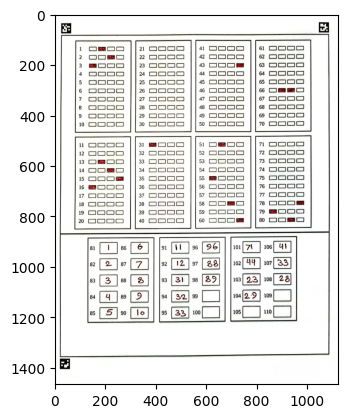

In [13]:
img = cv2.imread('./Final_test/test2.jpg')
h, w, _ = img.shape
size = 1600
aspect_ratio = w / h
img = cv2.resize(img, (int(size * aspect_ratio), size), cv2.INTER_CUBIC)
corners = getPaperCorners(img)
fx, fy = corners[0]
sx, sy = corners[1][0], corners[2][1]
fx, fy = (int(fx - 0.3 * fx), int(fy - 0.3 * fy))
sx, sy = (int(sx + 0.07 * sx), int(sy + 0.07 * sy))
img = img[fy:sy, fx:sx, :].copy()
plt.imshow(img)

## Get contours

In [14]:
def getContours(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 55, 55)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CROSS, np.ones((4, 4)))
    contours, hierarchies = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchies, thresh

## Blocks
Blocks are considered as TestBlocks and Writing blocks

In [15]:
BLOCK_AREA_LIMIT = 0.0045
BLOCK_POINT_LIMIT = 10

# Blocks
def countBlocks(contours, hierarchies, i, imgShape):
    h, w = imgShape
    j = hierarchies[0][i][2]
    cnt = 0
    while j != -1:
        area = cv2.contourArea(contours[j])
        rarea = area / (w * h)
        num_points = len(approximatePolygon(contours[j]))
        if num_points <= BLOCK_POINT_LIMIT and num_points >= 4 and  rarea >= BLOCK_AREA_LIMIT:
            cnt += 1
        j = hierarchies[0][j][0]
    return cnt


def getRealParent(contours, hierarchies, imgShape, numBlocks=12):
    areas = np.array([cv2.contourArea(contours[i]) for i in range(len(contours))], dtype='float32')
    indecies = np.argsort(areas)
    for i in indecies[::-1]:
        cnt = countBlocks(contours, hierarchies, i, imgShape)
        if cnt == numBlocks: return i
    return None


def getBlocks(contours, hierarchies, parent, imgShape):
    h, w = imgShape
    j = hierarchies[0][parent][2]
    lst = []
    while j != -1:
        area = cv2.contourArea(contours[j])
        rarea = area / (w * h)
        num_points = len(approximatePolygon(contours[j]))
        if num_points <= BLOCK_POINT_LIMIT and num_points >= 4 and  rarea >= BLOCK_AREA_LIMIT:
            lst.append(j)
        j = hierarchies[0][j][0]
    return lst


def getRectangles(contours):
    returns = []
    for i in range(len(contours)):
        contour = contours[i]
        rect = cv2.boundingRect(contour)
        x1, y1, x2, y2 = rect[0], rect[1], rect[2] + rect[0], rect[3] + rect[1]
        returns.append(((x1, y1), (x2, y2)))
    return returns


def getBlocksInOrder(contours, indecies):
    '''
    This method returns block indecies in order of their position.
    It will return the results in a way that number of questions are in order
    '''
    rects = getRectangles(contours)
    rects = sorted(zip(rects, range(len(rects))), key=lambda x: (x[0][0][0] // 100, x[0][0][1]))
    return [i[-1] for i in rects if i[-1] in indecies]


def approximatePolygon(contour):
    '''
    This method customly calculates the approximated polygon. Using this we can see
    whether the shape is a square or something else
    '''
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, closed=True)
    return approx

In [16]:
def getBlocksByImg(img, numBlocks=2, parent=None):
    contours, hierarchies, thresh = getContours(img) # get contours and hierarchies
    if parent is None:
        parent = getRealParent(contours, hierarchies, thresh.shape, numBlocks=numBlocks) # get the parent to get children as blocks
    blocks = getBlocks(contours, hierarchies, parent, thresh.shape) # find children as blocks
    res = getBlocksInOrder(contours, blocks) # sort for test blocks
    return contours, hierarchies, res, thresh

## Test boxes

In [17]:
AREA_LIMIT = 0.0045
POINT_LIMIT = 10
ASPECT_LIMIT = 1.2

def countSquares(contours, hierarchies, parent, imgShape):
    im_h, im_w = imgShape
    child = hierarchies[0][parent][2]
    cnt = 0
    while child != -1:
        area = cv2.contourArea(contours[child])
        rarea = area / (im_h * im_w)
        _, _, w, h = cv2.boundingRect(contours[child])
        aspectRatio = float(w) / h
        num_points = len(approximatePolygon(contours[child]))
        if num_points <= POINT_LIMIT and num_points >= 4 and  rarea >= AREA_LIMIT and aspectRatio >= ASPECT_LIMIT:
            cnt += 1
        child = hierarchies[0][child][0]
    return cnt
    
    
def getTestBoxParent(contours, hierarchies, imgShape, squares=40):
    areas = np.array([cv2.contourArea(contours[i]) for i in range(len(contours))], dtype='float32')
    indecies = np.argsort(areas)
    for i in indecies[::-1]:
        cnt = countSquares(contours, hierarchies, i, imgShape)
        if  cnt == squares:
            return i
    print('NO PARENT FOUND')
    return None


def getTestSquares(contours, hierarchies, parent, imgShape):
    '''
    Return the indicies for the test squares inside each block
    '''
    im_h, im_w = imgShape
    child = hierarchies[0][parent][2]
    lst = []
    while child != -1:
        _, _, w, h = cv2.boundingRect(contours[child])
        area = cv2.contourArea(contours[child])
        rarea = area / (im_w * im_h)
        aspectRatio = float(w) / h
        num_points = len(approximatePolygon(contours[child])) 
        if num_points <= POINT_LIMIT and num_points >= 4 and  rarea >= AREA_LIMIT and aspectRatio >= ASPECT_LIMIT:
            lst.append(child)
        child = hierarchies[0][child][0]
    return lst


def sortTestSquares(contours, square_indicies):
    rects = getRectangles(contours)
    rects = list(zip(range(len(rects)), rects))
    rects = sorted(rects, key=lambda x: (x[1][0][1] // 30, x[1][0][0] // 10))
    return [x[0] for x in rects if x[0] in square_indicies]


def checkSquare(square):
    if np.mean(square / 255.0) > 0.8:
        return 1
    return 0

In [18]:
def getTestSquaresByImg(img, numSquares=40, parent=None):
    contours, hierarchies = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if parent is None:
        parent = getTestBoxParent(contours, hierarchies, img.shape, squares=numSquares)
    squares = getTestSquares(contours, hierarchies, parent, img.shape)
    squares = sortTestSquares(contours, squares)
    return contours, hierarchies, squares

In [19]:
def test_results(img):
    contours, hierarchies, blocks, thresh = getBlocksByImg(img)
    rects = getRectangles(contours)
    i = 0 # Test part

    question = 1
    squares_checked = 0
    buffer = [0, 0, 0, 0]
    questions = {}
    
    # Get test Blocks
    tblocks = getBlocks(contours, hierarchies, blocks[i], thresh.shape)
    tblocks = getBlocksInOrder(contours, tblocks)
    trects = getRectangles(contours)
    for j in tblocks:
        tpoints = trects[j]
        test_block = thresh[tpoints[0][1]:tpoints[1][1], tpoints[0][0]:tpoints[1][0]].copy()
        #test_block = cv2.cvtColor(test_block, cv2.COLOR_BGR2GRAY)
        #test_block = cv2.adaptiveThreshold(test_block, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 99, 33)
        #test_block = cv2.morphologyEx(test_block, cv2.MORPH_CLOSE, np.ones((3, 3)))
        
        # Get squares
        scontours, shierarchies, sblocks = getTestSquaresByImg(test_block)
        srects = getRectangles(scontours)
        
        for k in sblocks:
            spoints = srects[k]
            square = test_block[spoints[0][1]:spoints[1][1], spoints[0][0]:spoints[1][0]].copy()
            result = checkSquare(square)
            buffer[squares_checked] = result
            squares_checked += 1

            if squares_checked == 4:
                squares_checked = 0
                if sum(buffer) > 1: questions[question] = -1
                elif sum(buffer) == 0: questions[question] = 0
                else: questions[question] = np.argmax(buffer) + 1
                question += 1
                buffer = [0, 0, 0, 0]
    return questions

In [20]:
test_results(img)

{1: 2,
 2: 3,
 3: 1,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 2,
 14: 3,
 15: 4,
 16: 1,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 1,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 4,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 2,
 52: 0,
 53: 0,
 54: 0,
 55: 1,
 56: 0,
 57: 0,
 58: 3,
 59: 0,
 60: 4,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: -1,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 4,
 79: 1,
 80: 3}

## Writing box

In [22]:
WAREA_LIMIT = 0.029
WPOINT_LIMIT = 8
WASPECT_LIMIT = 1.1

def countWritingBox(contours, hierarchies, parent, imgShape):
    im_h, im_w = imgShape
    child = hierarchies[0][parent][2]
    cnt = 0
    while child != -1:
        area = cv2.contourArea(contours[child])
        rarea = area / (im_h * im_w)
        _, _, w, h = cv2.boundingRect(contours[child])
        aspectRatio = float(w) / h
        num_points = len(approximatePolygon(contours[child])) 
        if num_points <= WPOINT_LIMIT and num_points >= 4 and  rarea >= WAREA_LIMIT and aspectRatio >= WASPECT_LIMIT:
            cnt += 1
        child = hierarchies[0][child][0]
    return cnt
    
    
def getWritingBoxParent(contours, hierarchies, imgShape, boxes=10):
    areas = np.array([cv2.contourArea(contours[i]) for i in range(len(contours))], dtype='float32')
    indecies = np.argsort(areas)
    for i in indecies[::-1]:
        cnt = countWritingBox(contours, hierarchies, i, imgShape)
        if  cnt == boxes:
            return i
    print('NO PARENT FOUND')
    return None


def getWritingBoxes(contours, hierarchies, parent, imgShape):
    '''
    Return the indicies for the Writing Boxes inside each block
    '''
    im_h, im_w = imgShape
    child = hierarchies[0][parent][2]
    lst = []
    while child != -1:
        _, _, w, h = cv2.boundingRect(contours[child])
        area = cv2.contourArea(contours[child])
        rarea = area / (im_w * im_h)
        aspectRatio = float(w) / h
        num_points = len(approximatePolygon(contours[child])) 
        if num_points <= WPOINT_LIMIT and num_points >= 4 and  rarea >= WAREA_LIMIT and aspectRatio >= WASPECT_LIMIT:
            lst.append(child)
        child = hierarchies[0][child][0]
    return lst


def sortWritingBoxes(contours, box_indicies):
    rects = getRectangles(contours)
    rects = list(zip(range(len(rects)), rects))
    rects = sorted(rects, key=lambda x: (x[1][0][0] // 100, x[1][0][1] // 10))
    return [x[0] for x in rects if x[0] in box_indicies]


def getNumberFromImage(image, verbose=False):
    states = cv2.connectedComponentsWithStats(image)
    lst = []
    for state in states[2]:
        x, y, width, height, centeriods = state
        if width > 50 or height > 40: continue
        if width < 4 or height < 4: continue
        morph_cropped = image[y:y + height, x: x + width].copy()
        morph_cropped = cv2.copyMakeBorder(morph_cropped, 6, 6, 13, 13, cv2.BORDER_CONSTANT)
        morph_cropped = cv2.resize(morph_cropped, (28, 28))
        _, thresh = cv2.threshold(morph_cropped, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((2, 2)))
        
        res = model.predict(thresh[np.newaxis, ..., np.newaxis] / 255.0, verbose=0)
        res = np.argmax(res)
        lst.append((res, x, y))

        if verbose:
            fig = plt.figure(figsize=(1, 1))
            ax = plt.subplot(1, 1, 1)
            ax.imshow(thresh, cmap='gray')

    lst = sorted(lst, key=lambda x: (x[1], x[2]))
    lst = [i[0] for i in lst]
    return int(''.join([str(i) for i in lst])) if len(lst) != 0 else ''

In [23]:
def getWritingBoxesByImg(img, num_boxes=10, parent=None):
    contours, hierarchies = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if parent is None:
        parent = getWritingBoxParent(contours, hierarchies, img.shape, boxes=num_boxes)
    boxes = getWritingBoxes(contours, hierarchies, parent, img.shape)
    boxes = sortWritingBoxes(contours, boxes)
    return contours, hierarchies, boxes

In [24]:
def writing_results(img, verbose=False):
    contours, hierarchies, blocks, thresh = getBlocksByImg(img)
    i = 1 # Writing part
    blocks = getBlocks(contours, hierarchies, blocks[i], thresh.shape)
    blocks = getBlocksInOrder(contours, blocks)
    rects = getRectangles(contours)
    answers = {}
    question = 1
    for block in blocks:
        (x1, y1),(x2, y2) = rects[block]
        wcropped = img[y1:y2, x1:x2, :].copy()
        wcropped = cv2.cvtColor(wcropped, cv2.COLOR_BGR2GRAY)
        wcropped = cv2.adaptiveThreshold(wcropped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 33, 33)
        wcontours, whierarchies, wblocks = getWritingBoxesByImg(wcropped, 10)
        wrects = getRectangles(wcontours)
        for wblock in wblocks:
            (x1, y1),(x2, y2) = wrects[wblock]
            acropped = wcropped[y1:y2, x1:x2].copy()
            h, w = acropped.shape
            acropped = acropped[int(0.09 * h): int(-0.09 * h), int(0.09 * w) : int(-0.09 * w)]
    
            _, thresh = cv2.threshold(acropped, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            #morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((2, 2)))
            #morph = thresh.copy()
            answer = getNumberFromImage(thresh, verbose)
            answers[question] = answer
            question += 1
    return answers

In [25]:
writing_results(img, False)

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 31,
 14: 32,
 15: 33,
 16: 96,
 17: 88,
 18: 89,
 19: '',
 20: '',
 21: 71,
 22: 44,
 23: 23,
 24: 29,
 25: '',
 26: 41,
 27: 33,
 28: 28,
 29: '',
 30: ''}